In [90]:
import torch
from torch import nn,optim
from torch.autograd import Variable
from torch.nn import init
from matplotlib import pyplot as plot
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker

## Reading Data

In [91]:
csvfile = pd.read_csv("../steering.csv")

In [92]:
print(csvfile.head(10))

             timestamp     angle  torque      speed
0  1479424214787219361  0.003491  0.1250  22.880556
1  1479424214807231859  0.003491  0.1250  22.886110
2  1479424214827300730  0.003491  0.1250  22.891666
3  1479424214847355643  0.003491  0.1875  22.897223
4  1479424214867355824  0.003491  0.0000  22.902779
5  1479424214887364135  0.003491  0.0625  22.905556
6  1479424214907399816  0.003491  0.2500  22.908333
7  1479424214927455132  0.003491 -0.0625  22.911112
8  1479424214947476806  0.001745  0.0000  22.913889
9  1479424214967638631  0.001745 -0.0625  22.913889


## Display the original angle

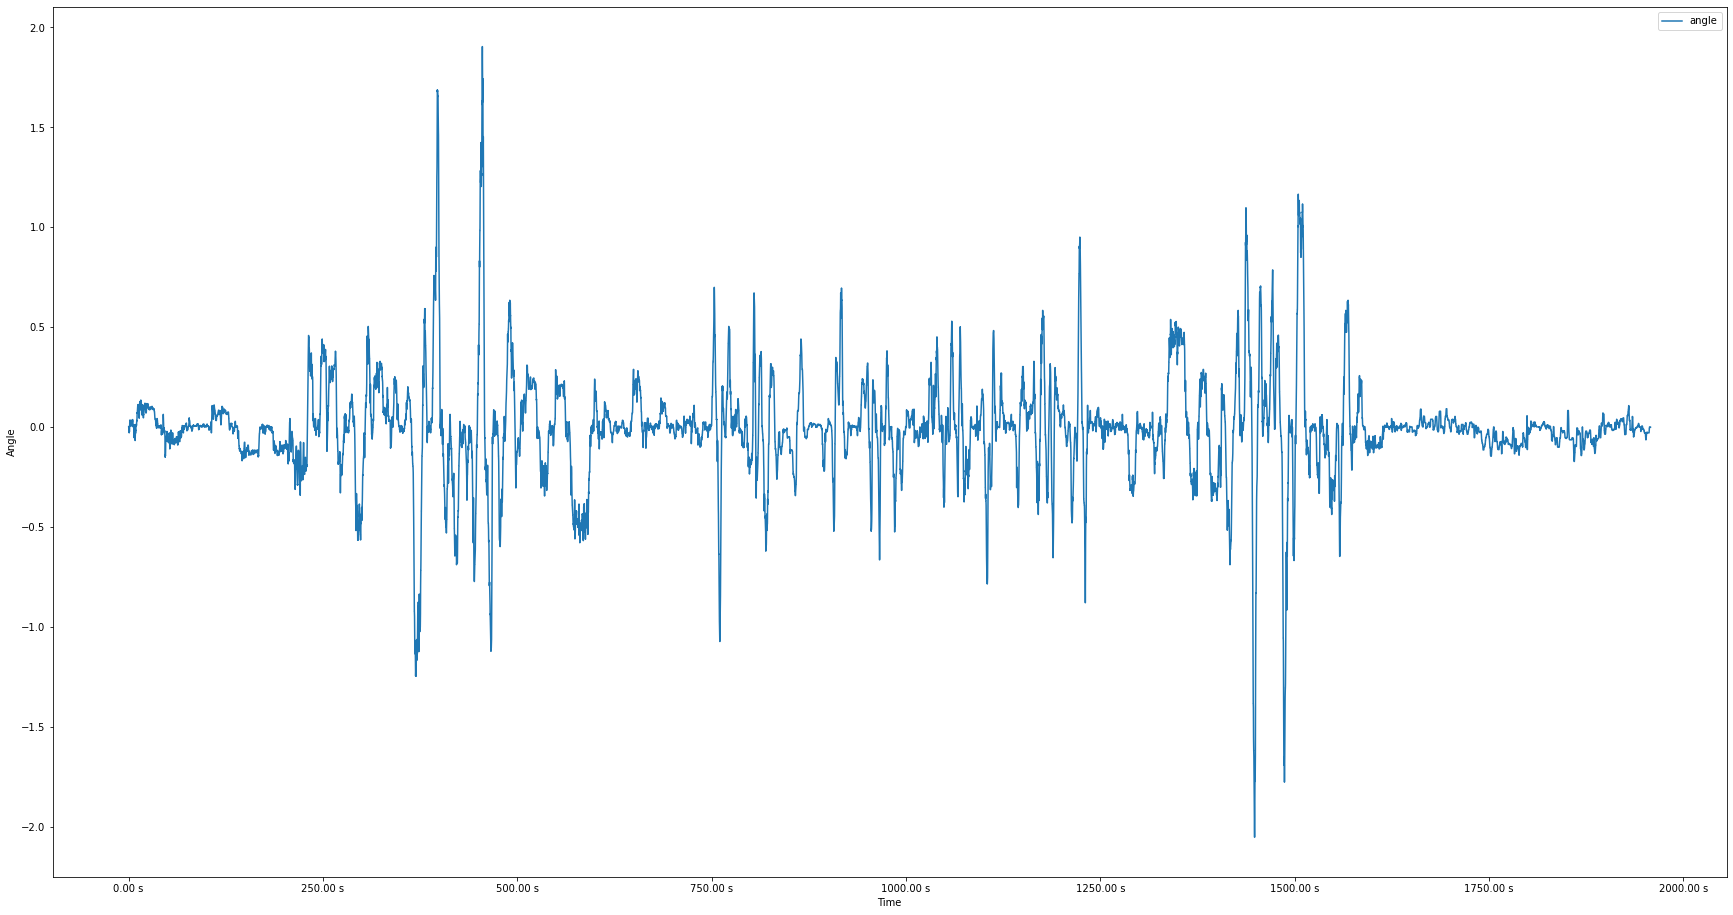

In [93]:
s = len(csvfile.angle)/50
x = np.arange(0,s ,0.02)
plot.figure(figsize=(30,16))
plot.plot(x, csvfile.angle,label='angle')
plot.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f s'))
plot.xlabel("Time")
plot.ylabel("Angle")
plot.legend()

In [94]:
angle = csvfile.angle
cut_off = len(angle)* 8 // 10
angle = angle[0:cut_off]

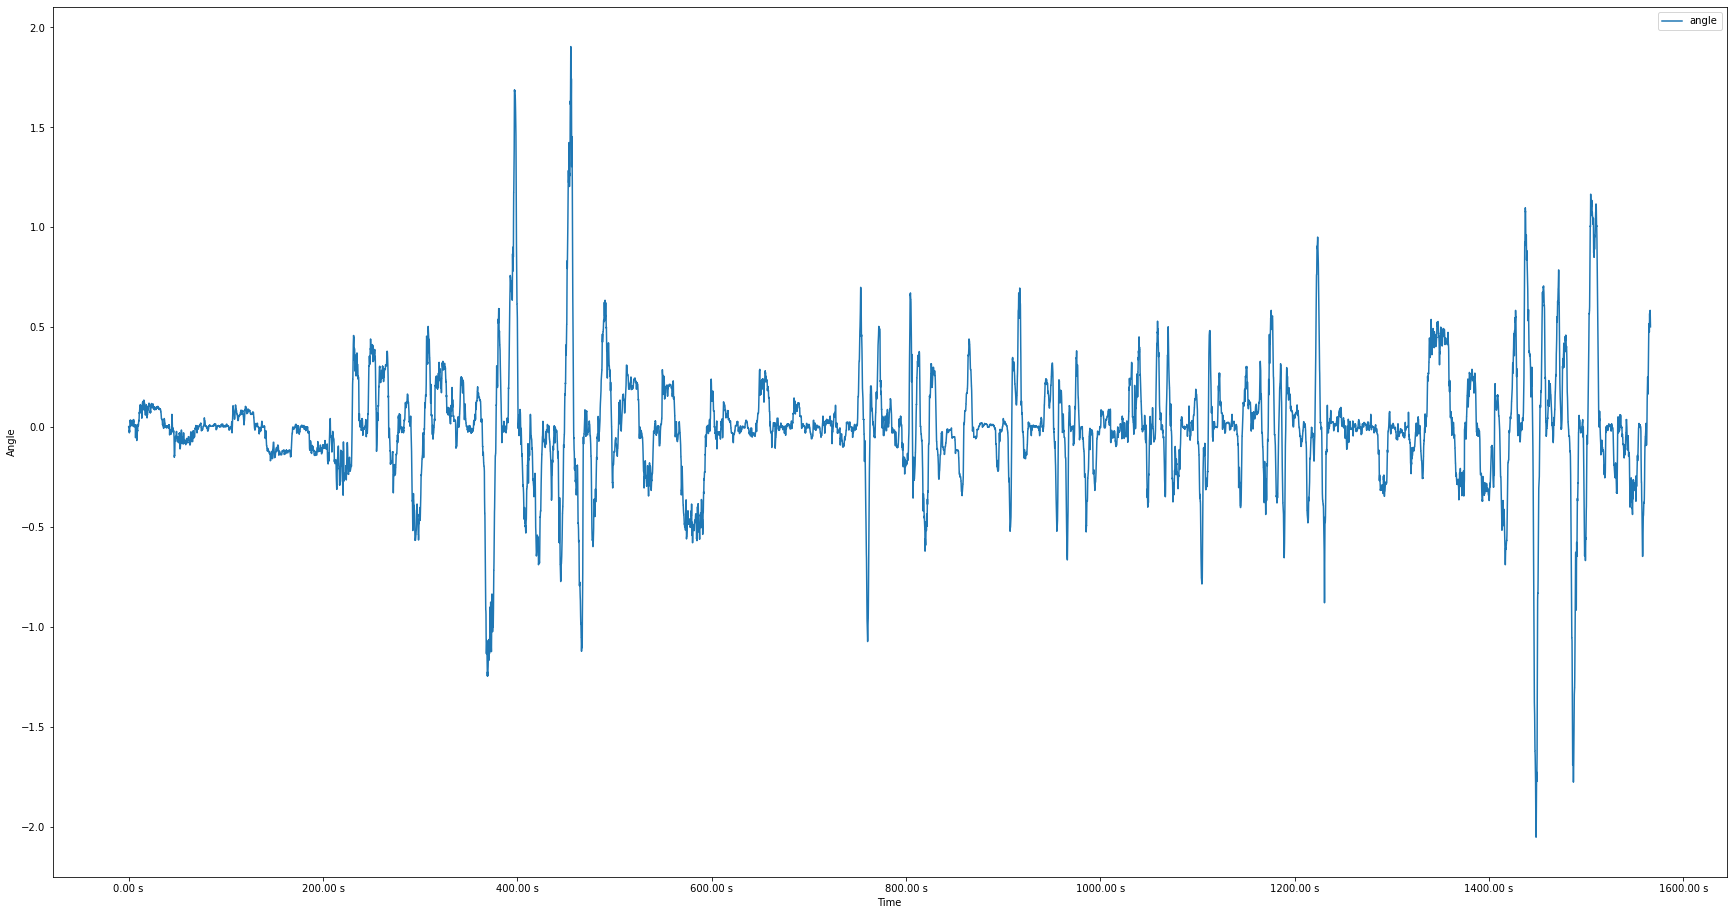

In [95]:
s = len(angle)/50
x = np.arange(0,s ,0.02)
plot.figure(figsize=(30,16))
plot.plot(x, angle,label='angle')
plot.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f s'))
plot.xlabel("Time")
plot.ylabel("Angle")
plot.legend()

In [96]:
len(angle), len(csvfile.angle)

(78309, 97887)

## Processing Data

In [97]:
nums = len(angle)
data = np.array(angle)
data = data.reshape(nums,1)

In [98]:
len(data)

78309

In [99]:
train_num = nums * 7 //10
validation_num = nums //10
test_num = nums - train_num - validation_num
train_data = data[0:train_num-1]
train_label = data[1:train_num]

In [100]:
validation_data = data[train_num:nums - test_num-1]
validation_label = data[train_num+1: nums - test_num]

In [101]:
test_data = data[train_num+ validation_num:nums-1]
test_label = data[train_num+validation_num+1: nums]

## Model

In [102]:
class rnnModel(nn.Module):
    def __init__(self,in_dim,hidden_dim,out_dim,layer_num):
        super().__init__()
        self.fcLayer=nn.Linear(hidden_dim,out_dim)
        self.lstm = nn.LSTM(in_dim, hidden_dim, layer_num)

    def forward(self, x):
        out,_=self.lstm(x)
        out=self.fcLayer(out)
        return  out

    def weightInit(self,gain=1):
        for name ,param in self.named_parameters():
            if 'rnnLayer.weight' in name:
                init.orthogonal(param,gain)


## One sample Training and Testing

In [ ]:
rnn_one=rnnModel(1,20,1,10)
rnn_one = rnn_one.cuda()
criterion_one=nn.MSELoss()
criterion_one = criterion_one.cuda()
optimizer_one=optim.Adam(rnn_one.parameters(),lr=1e-3)
epoches = 500


# Train
for i in range(0, epoches):
    
    #initialize
    initial_data = torch.from_numpy(train_data[0].astype(np.float32)).reshape(1,1,1)
    inputs = initial_data
    outputs_train = []
    loss_train = []
    rnn_one.train()
    for e in range(0, len(train_data)) :
        
        # forward
        inputs = Variable(inputs)
        inputs = inputs.cuda()
        output = rnn_one(inputs)
        inputs = output
        
        # loss backforward and optimize
        target = Variable(torch.from_numpy(train_label[e].astype(np.float32)).reshape(1,1,1))
        target = target.cuda()
        loss = criterion_one(output, target)
        optimizer_one.zero_grad()
        loss.backward()
        optimizer_one.step()
        
        loss_train.append(loss.cpu().item())
        outputs_train.append(output.cpu().item())
    print('Epoch [{}/{}],train_loss = {:.10f}'.format(i,epoches, np.mean(loss_train)))  
    
    #validation
    #initialize
    initial_data = torch.from_numpy(validation_data[0].astype(np.float32)).reshape(1,1,1)
    inputs = initial_data
    outputs_val = []
    loss_val = []
    rnn_one.eval()
    with torch.no_grad():
        for e in range(0, len(validation_data)):
            #forward
            inputs = Variable(inputs)
            inputs = inputs.cuda()
            output = rnn_one(inputs)
            outputs_val.append(output.cpu().item())
            inputs = output

            #calculate loss
            target = Variable(torch.from_numpy(validation_label[e].astype(np.float32)).reshape(1,1,1))
            target = target.cuda()
            loss = criterion_one(output, target)
            loss_val.append(loss.cpu().item())
        print('validation_loss = {:.10f}'.format(np.mean(loss_val)))      
    
    
#Test       
    
#initialize
initial_data = torch.from_numpy(test_data[0].astype(np.float32)).reshape(1,1,1)
inputs = initial_data
outputs_test = []
loss_test = []
rnn_one.eval()
with torch.no_grad():
    for e in range(0, len(test_data)):
        #forward
        inputs = Variable(inputs)
        inputs = inputs.cuda()
        output = rnn_one(inputs)
        outputs_test.append(output.cpu().item())
        inputs = output

        #calculate loss
        target = Variable(torch.from_numpy(test_label[e].astype(np.float32)).reshape(1,1,1))
        target = target.cuda()
        loss = criterion_one(output, target)
        loss_test.append(loss.cpu().item())
    print('test_loss = {:.10f}'.format(np.mean(loss_test)))     

Epoch [0/500],train_loss = 0.0030578401
validation_loss = 0.0606111904
Epoch [1/500],train_loss = 0.0048086676
validation_loss = 0.0617819966
Epoch [2/500],train_loss = 0.0039110806
validation_loss = 0.0612426561
Epoch [3/500],train_loss = 0.0023578293
validation_loss = 0.0640822093
Epoch [4/500],train_loss = 0.0039943198
validation_loss = 0.0612176884
Epoch [5/500],train_loss = 0.0034508514
validation_loss = 0.0615452740
Epoch [6/500],train_loss = 0.0046268018
validation_loss = 0.0616963045
Epoch [7/500],train_loss = 0.0034040283
validation_loss = 0.0620373452
Epoch [8/500],train_loss = 0.0015656277
validation_loss = 0.0626348814
Epoch [9/500],train_loss = 0.0013646081
validation_loss = 0.0630510991
Epoch [10/500],train_loss = 0.0020182532
validation_loss = 0.0629581611
Epoch [11/500],train_loss = 0.0029048497
validation_loss = 0.0614986037
Epoch [12/500],train_loss = 0.0028610006
validation_loss = 0.0608750995
Epoch [13/500],train_loss = 0.0017461740
validation_loss = 0.0632275709
Ep

Epoch [114/500],train_loss = 0.0023978699
validation_loss = 0.0612538408
Epoch [115/500],train_loss = 0.0033013704
validation_loss = 0.0633921801
Epoch [116/500],train_loss = 0.0033963256
validation_loss = 0.0620211595
Epoch [117/500],train_loss = 0.0029163322
validation_loss = 0.0610759736
Epoch [118/500],train_loss = 0.0027919671
validation_loss = 0.0615928432
Epoch [119/500],train_loss = 0.0021937866
validation_loss = 0.0617289513
Epoch [120/500],train_loss = 0.0022967599
validation_loss = 0.0615311367
Epoch [121/500],train_loss = 0.0019924324
validation_loss = 0.0640371316
Epoch [122/500],train_loss = 0.0014090777
validation_loss = 0.0642003855
Epoch [123/500],train_loss = 0.0031781093
validation_loss = 0.0620027660
Epoch [124/500],train_loss = 0.0032320934
validation_loss = 0.0605358024
Epoch [125/500],train_loss = 0.0056205183
validation_loss = 0.0604210158
Epoch [126/500],train_loss = 0.0025514310
validation_loss = 0.0608123407
Epoch [127/500],train_loss = 0.0024825847
validatio

validation_loss = 0.0639063709
Epoch [227/500],train_loss = 0.0010125561
validation_loss = 0.0640513936
Epoch [228/500],train_loss = 0.0035988103
validation_loss = 0.0640549387
Epoch [229/500],train_loss = 0.0028742949
validation_loss = 0.0626449299
Epoch [230/500],train_loss = 0.0031737471
validation_loss = 0.0633357875
Epoch [231/500],train_loss = 0.0027057926
validation_loss = 0.0612896398
Epoch [232/500],train_loss = 0.0038936323
validation_loss = 0.0614285434
Epoch [233/500],train_loss = 0.0019578095
validation_loss = 0.0633110376
Epoch [234/500],train_loss = 0.0032992828
validation_loss = 0.0611300021
Epoch [235/500],train_loss = 0.0024040318
validation_loss = 0.0609304034
Epoch [236/500],train_loss = 0.0020504722
validation_loss = 0.0623127491
Epoch [237/500],train_loss = 0.0047752239
validation_loss = 0.0608311995
Epoch [238/500],train_loss = 0.0046142134
validation_loss = 0.0607007379
Epoch [239/500],train_loss = 0.0065848326
validation_loss = 0.0605720753
Epoch [240/500],trai

## Training graph of Predicted Data and Ground Truth

In [ ]:
plot.figure(figsize=(30,16))
plot.plot(range(0,len(outputs_train)), outputs_train,label='predict_angle')
plot.plot(range(0,len(outputs_train)), train_label,label='ground truth')
plot.xlabel("steps")

plot.legend()

## Testing graph of Predicted Data and Ground Truth

In [ ]:
plot.figure(figsize=(30,16))
plot.plot(range(0,len(outputs_test)), outputs_test,label='predict_angle')
plot.plot(range(0,len(outputs_test)), test_label,label='ground truth')
plot.xlabel("steps")
plot.legend()

In [ ]:
initial_data = torch.from_numpy(test_data[0].astype(np.float32)).reshape(1,1,1)
inputs = initial_data
outputs_test = []
loss_test = []
rnn_one.eval()
with torch.no_grad():
    for e in range(0, len(test_data)):
        #forward
        inputs = Variable(inputs)
        inputs = inputs.cuda()
        output = rnn_one(inputs)
        outputs_test.append(output.cpu().item())
        inputs = output

        #calculate loss
        target = Variable(torch.from_numpy(test_label[e].astype(np.float32)).reshape(1,1,1))
        target = target.cuda()
        loss = criterion_one(output, target)
        loss_test.append(loss.cpu().item())
    print('test_loss = {:.10f}'.format(np.mean(loss_test)))  

In [ ]:
initial_data = torch.from_numpy(test_data[0].astype(np.float32)).reshape(1,1,1)
inputs = initial_data

In [ ]:
inputs = Variable(inputs)
inputs = inputs.cuda()
output = rnn_one(inputs)

In [ ]:
output.cpu().item()

In [ ]:
initial_data

In [ ]:
test_data